# Trajectory Inference for Hematopoiesis in Mouse

This tutorial aims to reconstruct myeloid and erythroid differentiation for data from Paul et al. (2015).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3,3), facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [4]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

This is not a required but lets set to a higher percision than 'float32' so we get same results across different computational platforms.

In [6]:
adata.X = adata.X.astype('float64')

## Preprocessing and Visualization

We will start by apply a simple prefigured preprocessing recipe.

In [7]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [8]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [11]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:17)


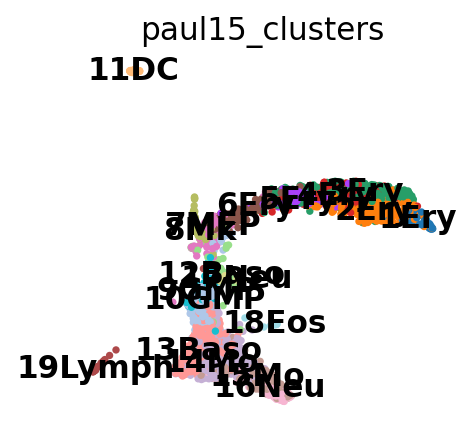

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This does not look nice.

## Denoising the Graph

If we want to denoise the graph we need to not plot in PCA space but in a diffusion map space. We take just a few of the first spectral components. A few papers linked in the tutorial discuss this. Below I will show the code for how to do it.

In [13]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [14]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


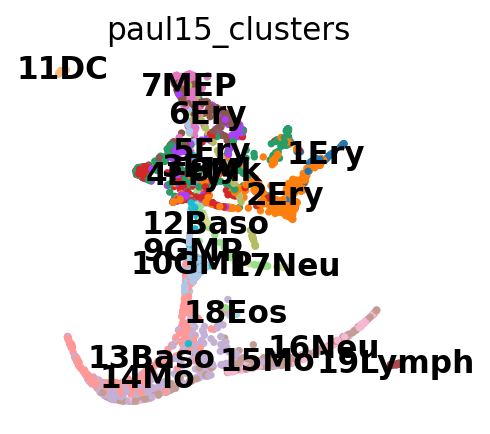

In [15]:
sc.pl.draw_graph(adata,color='paul15_clusters', legend_loc='on data')

This is still messy.

## Clustering and PAGA

One thing to note... in this tutorial we use louvain algorithm for clustering because it better reproduces the results of the paper, but nowadays we use the leiden algorithm.

In [17]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


| **cell type** | **marker** |
|---|---|
|HSCs|Procr|
|Erythroids|Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1|
|Neutrophils|Elane, Cebpe, Ctsg, Mpo, Gfi1|
|Monocytes|Irf8, Csf1r, Ctsg, Mpo|
|Megakaryocytes|Itga2b (encodes CD41), Pbx1, Sdpr, Vwf|
|Basophils|Mcpt8, Prss34|
|B cells| Cd19, Vpreb2, Cd79a|
|Mast cells| Cma1, Gzmb, CD117/C-Kit|
|Mast cells & Basophils|Ms4a2, Fcer1a, Cpa3, CD203c (human)|

In [18]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


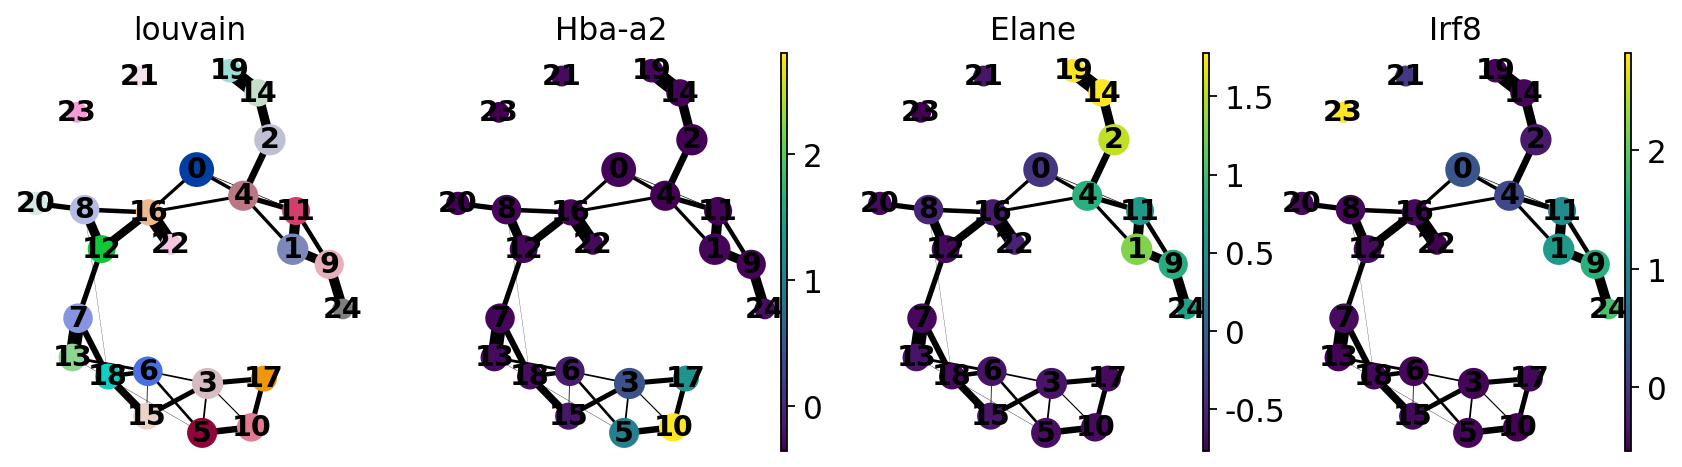

In [19]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

My question is... how are these numbered. How do we know what the trajectories mean?

--> added 'pos', the PAGA positions (adata.uns['paga'])


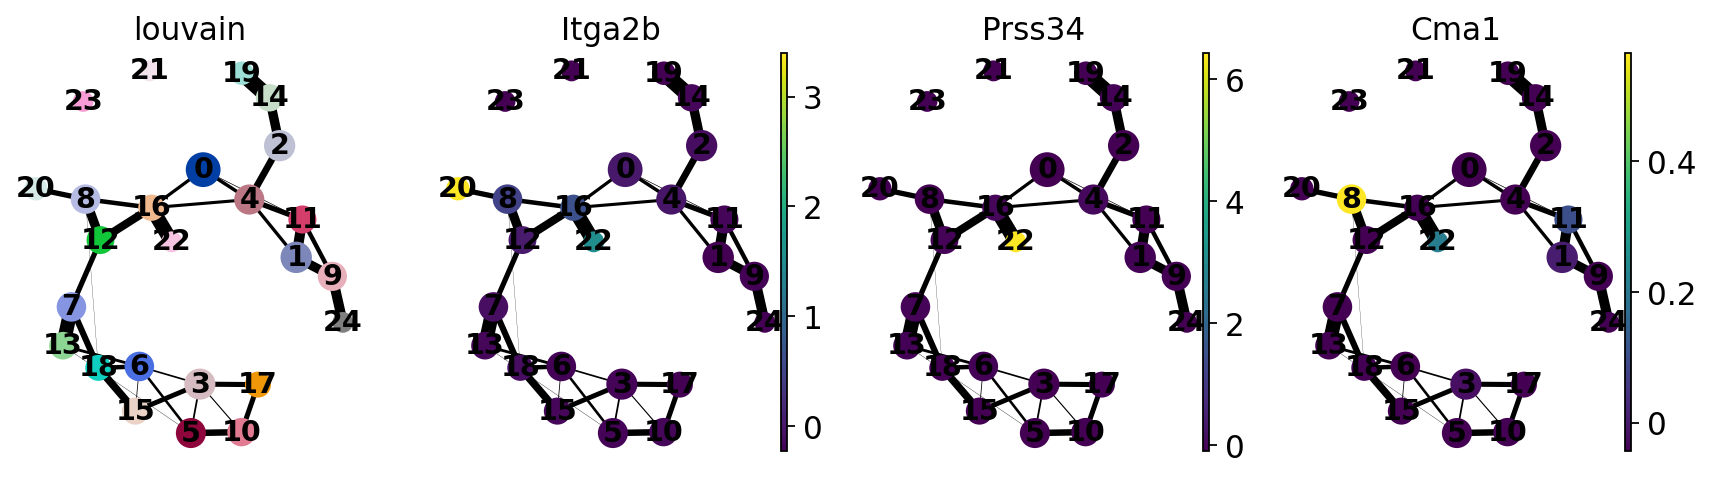

In [20]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Let's use these to annotate the clusters.

In [22]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [23]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [41]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6',
                                           '7', '8', '9', '10/Ery', '11', '12', '13',
                                           '14', '15', '16/Stem', '17', '18',
                                           '19/Neu', '20/Mk', '21', '22/Baso',
                                           '23', '24/Mo']

How did we know that cluster 16 was a Stem cell?

In [25]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


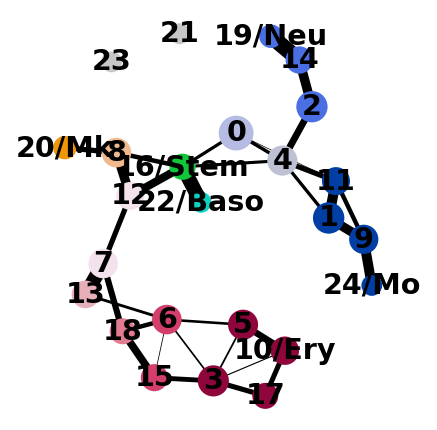

In [45]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the Embedding and using PAGA-Initialization

In [27]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:15)


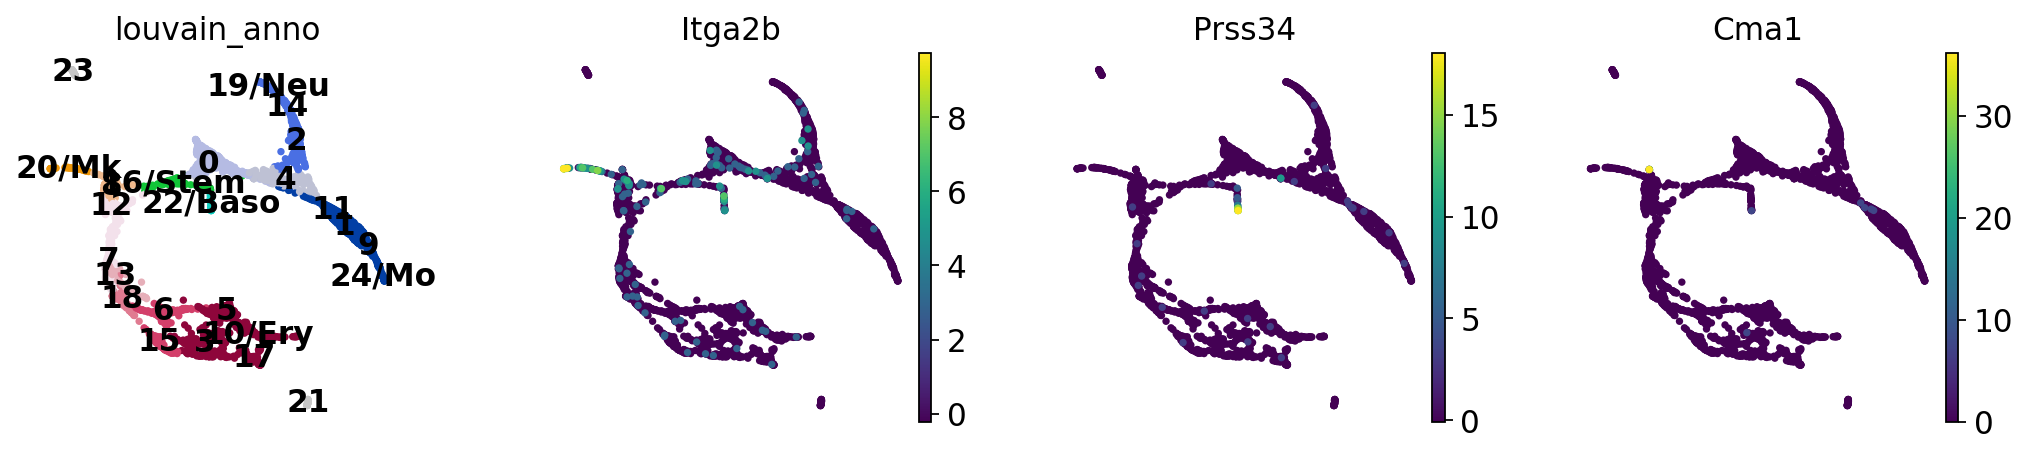

In [44]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Let's choose some colors

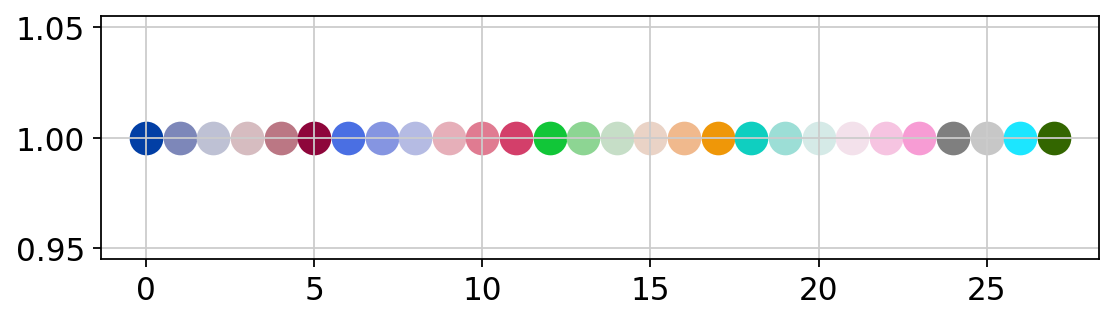

In [31]:
plt.figure(figsize=(8, 2))
for i in range(28):
    pltzeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors']).scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
plt.show()

In [32]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [33]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [34]:
adata.uns['louvain_anno_colors'] = new_colors

--> added 'pos', the PAGA positions (adata.uns['paga'])


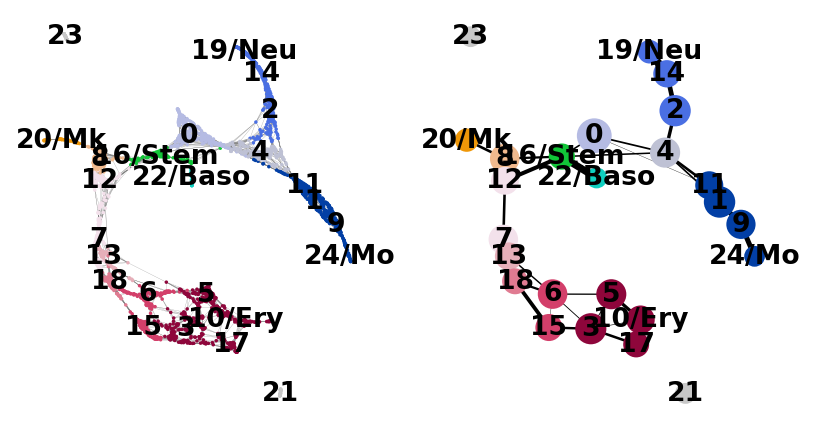

In [43]:
sc.pl.paga_compare(adata, threshold=0.03, title='', right_margin=0.2, 
                  size=10, edge_width_scale=0.5, legend_fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing Gene Changes Along PAGA Paths for a Given Set of Genes

Choose a root cell for diffusion pseudotime.

I assume this means to that you choose one that has the expression profile closest to that of an HSC and infer differentiation paths in pseudotime analysis.

In [36]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno'] == '16/Stem')[0]

In [37]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Select some marker gene names.

In [38]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use full raw data for visualization.

In [39]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


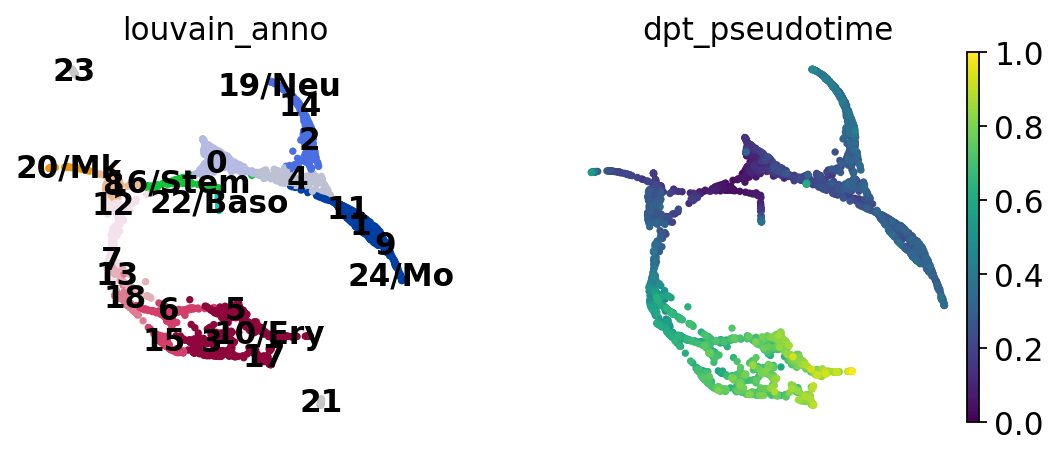

In [46]:
sc.pl.draw_graph(adata, color =['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [47]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [48]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [50]:
adata.obs['clusters'] = adata.obs['louvain_anno'] #cosmetic change

In [51]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

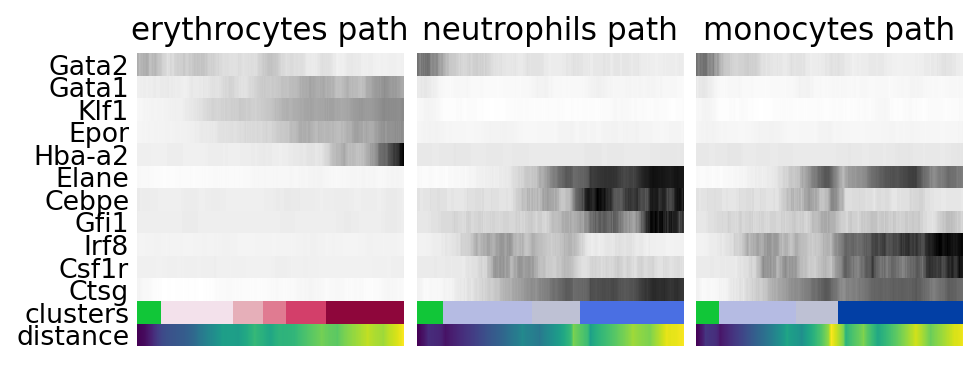

In [55]:
_, axs = plt.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./data/paga_path_{}.csv'.format(descr))
plt.savefig('./figures/paga_path_paul15.pdf')
plt.show()